Import Libraries

In [37]:
import pandas as pd 
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import PIL
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from torch.utils.data import random_split

In [38]:
folder_path = 'Auto_ZMJ2N'

In [39]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index]['filename']
        # Convert all labels to 'OK' vs all others for binary classification
        labels = self.df.iloc[index][1:].values.astype(float)
        binary_label = 1 if 'OK' in filename else 0
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.tensor(binary_label)

In [50]:
torch.manual_seed(42)
# test_path = os.path.join(folder_path, 'test')
test_path = 'kaggle_1/test'
train_path = os.path.join(folder_path, 'train')
csv_path = os.path.join(folder_path, 'classes.csv')
df = pd.read_csv(csv_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Create the full dataset from the CSV
full_dataset = CustomDataset(csv_path, train_path, transform=transform)

# Splitting the full dataset into train and validation sets
total_size = len(full_dataset)
train_size = int(total_size * 0.8)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create the test dataset
# test_dataset = datasets.ImageFolder(test_path, transform=transform)
# test_dataset.classes

In [51]:
# Create the test dataset with binary labels
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.transform = transform
        self.image_files = os.listdir(images_folder)
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        filename = self.image_files[index]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        
        # Determine the label based on the filename or directory structure
        if 'OK' in filename:  # Assuming filenames contain 'OK' for positive class
            label = 1  # Positive class
        else:
            label = 0  # Negative class
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, torch.tensor(label)

# Create the test dataset
test_dataset = CustomTestDataset(test_path, transform=transform)
test_dataset.classes = ['defected', 'no_defected']  

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_of_classes = 1
model = models.efficientnet_v2_l(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Linear(num_ftrs, num_of_classes)
model.to(device)

/home/jadhaiza/miniconda3/envs/ka/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jadhaiza/miniconda3/envs/ka/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [53]:
# Hyper parameters 
epochs = 20
lr = 1e-2
batch_size = 64

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader =  DataLoader(test_dataset, batch_size=batch_size)

In [55]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batch")):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = correct / total * 100
        
    train_loss_history.append(running_loss / len(train_loader))
    train_acc_history.append(accuracy)
    
    # Validation
    val_running_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        val_accuracy = val_correct / val_total * 100
    val_loss_history.append(val_running_loss / len(val_loader))
    val_acc_history.append(val_accuracy)
    
    print(f'Train loss: {running_loss / len(train_loader):.3f}, Train accuracy: {accuracy:.2f}%, Val loss: {val_running_loss / len(val_loader):.3f}, Val accuracy: {val_accuracy:.2f}%')
    
    # Early stopping
    if val_running_loss / len(val_loader) < best_val_loss:
        best_val_loss = val_running_loss / len(val_loader)
        best_model_state = model.state_dict()
    else:
        print(f"Validation loss did not improve from {best_val_loss:.3f}.")
        break

model.load_state_dict(best_model_state)

Epoch 1:   0%|                                                          | 0/26 [00:01<?, ?batch/s]
/opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [9,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [11,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [13,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cuda/Loss.cu:250: 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


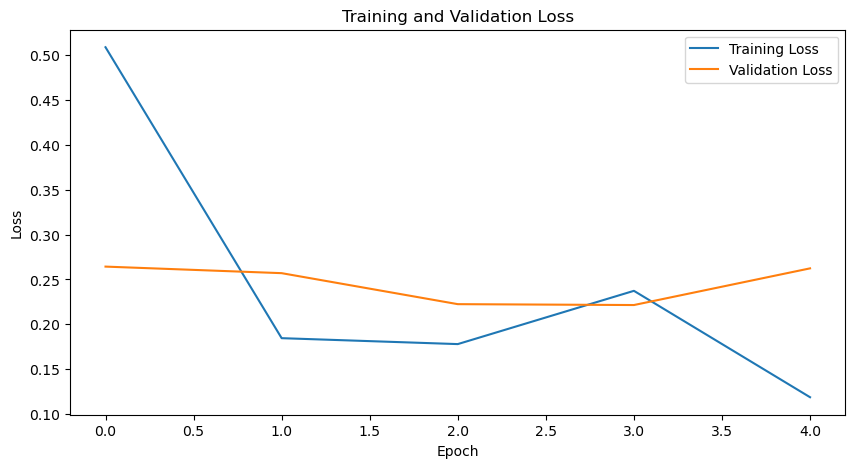

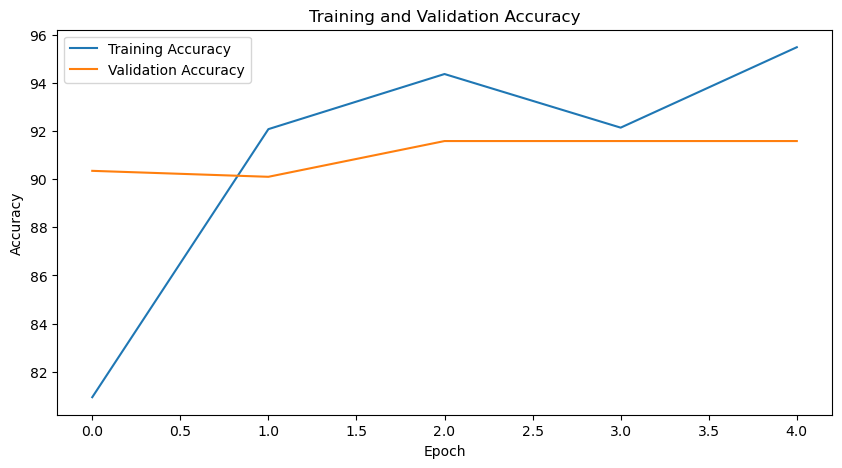

In [45]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [46]:
# Define a mapping for label alignment
label_mapping = {
    0: 0,  # Keep class 0 as is
    1: 3,  # Map class 1 to 3
    2: 1,  # Map class 2 to 1
    3: 2   # Map class 3 to 2
}

In [47]:
model.eval()

correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Apply the label mapping
        real = torch.tensor([label_mapping[label.item()] for label in labels], device=device)

        total += labels.size(0)
        all_labels.extend(real.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        correct += (predicted == real).sum().item()

accuracy = correct / total * 100
print(f'Test Accuracy: {accuracy:.2f}%') 

Test Accuracy: 46.01%


In [49]:
# report = classification_report(all_labels, all_preds, target_names=['OK','Spaghetti','stringing','blobs'])
report = classification_report(all_labels, all_preds, target_names=['OK','NOT OK'])
print(report)

ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

In [ ]:
model_path = 'model.pth'
torch.save(model.state_dict(), model_path)
model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f'Model Size: {model_size:.2f} MB')
os.remove(model_path)

Model Size: 449.67 MB


In [ ]:
import time


model.eval()
input_tensor = torch.randn(1, 3, 224, 224)
input_tensor = input_tensor.to('cpu')  

with torch.no_grad():
    start_time = time.time()
    output = model(input_tensor)
    end_time = time.time()

inference_time = end_time - start_time
print(f'Inference Time: {inference_time:.4f} seconds')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor